# The Battle of the NeighborHoods (Week 5)

# Download the data of New York geographical co-ordinates

In [74]:
# Import libraries
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors

In [75]:
# Download the dataset from https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json

#Load data and explore
import json
with open('nyu_2451_34572-geojson.json') as data:
    data = json.load(data)


In [78]:
#Store the features data as neighborhood_data
neighborhood_data = data['features']
neighborhood_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [79]:
# Transform the data into dataframe

#Define column names
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

#Define the dataframe
data = pd.DataFrame(columns = column_names)
data

,Borough,Neighborhood,Latitude,Longitude


In [80]:
#Fill the data to dataframe from dictionary with one row at a time
for data_ in neighborhood_data:
    borough = data_['properties']['borough']
    name = data_['properties']['name']
    latitude = data_['geometry']['coordinates'][1]
    longitude = data_['geometry']['coordinates'][0]

    data = data.append({'Borough' : borough, 'Neighborhood' : name, 'Latitude' : latitude, 'Longitude' : longitude}, ignore_index = True)

data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [81]:
#Save the dataframe to csv before transformation for later use
data.to_csv('NewYork_Geo.csv')

# Get the latitude and longitude of the New York

In [82]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent = 'Jupyter')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("For New York City, Latitude: {}, Longitude: {}".format(latitude, longitude))

For New York City, Latitude: 40.7127281, Longitude: -74.0060152


# Web scrapping of Population data of New York city from Wikipedia

In [83]:
# Scrape data from wikipedia page
from bs4 import BeautifulSoup 
import requests

#Get the url data in text form
url = 'https://en.wikipedia.org/wiki/Demographics_of_New_York_City'
webdata = requests.get(url).text

In [84]:
#Get the table data in html
soup = BeautifulSoup(webdata, 'lxml')
table = soup.find('table', {'class' : 'wikitable sortable'})


In [85]:
#Find the headers
headers = [header.text for header in table.find_all('th')]

#Find the table rows and then cell
table_rows = table.find_all('tr')
rows = []

for row in table_rows:
    td = row.find_all('td')
    row = [row.text for row in td]
    rows.append(row)


In [86]:
#Convert data to DataFrame
temp = pd.DataFrame(rows)
temp.columns = ['Borough', 'County', 'Estimate 2020', 't1','t2', 'square_miles', 'square_km', 'persons_sq_mi', 'persons_sq_km']

In [87]:
temp.drop(temp[['t1', 't2']], axis = 1, inplace = True)

In [88]:
temp = temp.drop([0, 1, 2, 10], inplace = False)
temp.reset_index(drop = True, inplace = True)

In [89]:
temp['Borough'] = temp['Borough'].replace(to_replace='\n', value='', regex=True)
temp['County'] = temp['County'].replace(to_replace='\n', value='', regex=True)
temp['Estimate 2020'] = temp['Estimate 2020'].replace(to_replace='\n', value='', regex=True)
temp['square_miles'] = temp['square_miles'].replace(to_replace='\n', value='', regex=True)
temp['square_km'] = temp['square_km'].replace(to_replace='\n', value='', regex=True)
temp['persons_sq_mi'] = temp['persons_sq_mi'].replace(to_replace='\n', value='', regex=True)
temp['persons_sq_km'] = temp['persons_sq_km'].replace(to_replace='\n', value='', regex=True)
temp

,Borough,County,Estimate 2020,square_miles,square_km,persons_sq_mi,persons_sq_km
0,The Bronx,Bronx,"1,432,132",42.10,109.04,"34,653","13,231"
1,Brooklyn,Kings,"2,582,830",70.82,183.42,"37,137","14,649"
2,Manhattan,New York,"1,628,701",22.83,59.13,"72,033","27,826"
3,Queens,Queens,"2,278,906",108.53,281.09,"21,460","8,354"
4,Staten Island,Richmond,"476,179",58.37,151.18,"8,112","3,132"
5,City of New York,"8,398,748",842.343,783.83,"28,188","10,947",None
6,State of New York,"19,745,289","1,701.399","122,284",416.4,159,None


In [90]:
#Shift data in the last two rows
temp.loc[5:,['persons_sq_mi','persons_sq_km']] = temp.loc[2:,['persons_sq_mi','persons_sq_km']].shift(1,axis=1)
temp.loc[5:,['square_km','persons_sq_mi']] = temp.loc[2:,['square_km','persons_sq_mi']].shift(1,axis=1)
temp.loc[5:,['square_miles','square_km']] = temp.loc[2:,['square_miles','square_km']].shift(1,axis=1)
temp.loc[5:,['Estimate 2020','square_miles']] = temp.loc[2:,['Estimate 2020','square_miles']].shift(1,axis=1)
temp.loc[5:,['County','Estimate 2020']] = temp.loc[2:,['County','Estimate 2020']].shift(1,axis=1)
temp.loc[5:,['Borough','County']] = temp.loc[2:,['Borough','County']].shift(1,axis=1)


In [91]:
temp = temp.fillna(' ')

In [92]:
temp

,Borough,County,Estimate 2020,square_miles,square_km,persons_sq_mi,persons_sq_km
0,The Bronx,Bronx,"1,432,132",42.10,109.04,"34,653","13,231"
1,Brooklyn,Kings,"2,582,830",70.82,183.42,"37,137","14,649"
2,Manhattan,New York,"1,628,701",22.83,59.13,"72,033","27,826"
3,Queens,Queens,"2,278,906",108.53,281.09,"21,460","8,354"
4,Staten Island,Richmond,"476,179",58.37,151.18,"8,112","3,132"
5,,City of New York,"8,398,748",842.343,783.83,"28,188","10,947"
6,,State of New York,"19,745,289","1,701.399","122,284",416.4,159


In [93]:
#Save to csv
temp.to_csv('New_York_Population.csv')

# Download and Explore Farmers Market dataset

In [94]:
# Data from website - https://data.cityofnewyork.us/dataset/DOHMH-Farmers-Markets-and-Food-Boxes/8vwk-6iz2

# Read the CSV data file from the object storage into a pandas DataFrame
farmers_data = pd.read_csv("Farmers_Markets.csv")
farmers_data.head()

,Borough,Market Name,Street Address,Latitude,Longitude,Days of Operation,Hours of Operations,Season Dates,Accepts EBT,Open Year-Round,Stellar Cooking Demonstrations,Food Activities for Kids,Location Point
0,Brooklyn,Woodhull Hospital Youthmarket,Broadway & Flushing Ave,40.700726,-73.941932,Wednesday,9 a.m. - 2 p.m.,07/10/2019-11/27/2019,Yes,No,No,No,"(40.700726, -73.941932)"
1,Manhattan,Mount Sinai Hospital Greenmarket,E 99th St bet Madison & Park Aves,40.789169,-73.952743,Wednesday,8 a.m. - 5 p.m.,06/12/19-11/27/19,Yes,No,No,No,"(40.789169, -73.952743)"
2,Bronx,170 Farm Stand,E 170th St & Townsend Ave,40.839882,-73.916783,Wednesday,2:30 - 6:30 p.m.,07/10/2019-11/27/2019,Yes,No,No,Yes,"(40.839882, -73.916783)"
3,Manhattan,Greenmarket at Oculus Plaza,"Church & Fulton Sts, on Oculus Plaza",40.711535,-74.010464,Tuesday,7 a.m. - 7 p.m.,07/09/2019-11/30/19,Yes,Yes,No,No,"(40.711535, -74.010464)"
4,Queens,Ditmars Park Youthmarket,"Steinway St bet Ditmars Blvd & 23rd Ave, at Di...",40.772854,-73.906061,Saturday,8 a.m. - 3 p.m.,07/13/2019-11/23/2019,Yes,No,No,No,"(40.772854, -73.906061)"


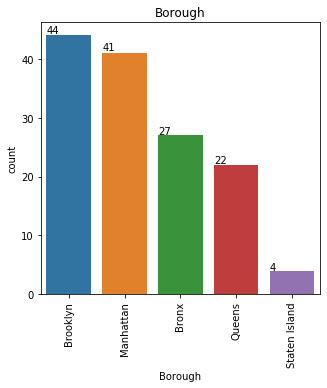

In [95]:
# Visualization of the data to check the cities
import seaborn as sns
fig,ax = plt.subplots(1, 1, figsize=(5, 5))
sns.countplot(x='Borough',data=farmers_data)
ax.set_title("Borough")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate('', (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))
        ax.set_xticklabels([t.get_text().split("T")[0] for t in ax.get_xticklabels()])

# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.xticks(rotation=90) 
plt.show()

# Use geopy library to get the latitude and longitude values of New York City

In [96]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="Jupyter")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


# Create a map of New York with Facility name and Borough of Farmers Market superimposed on top

In [97]:
# create map of New York City using latitude and longitude values
map_markets = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Market_Name, borough in zip(farmers_data['Latitude'], farmers_data['Longitude'], farmers_data['Market Name'], farmers_data['Borough']):
            label = '{}, {}'.format(Market_Name, borough)
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='blue',
                fill=True,
                fill_color='blue',
                fill_opacity=1,
                parse_html = False).add_to(map_markets)  

map_markets

# Segmenting and Clustering Neighborhoods - Brooklyn and Manhattan

# Introduction
In this section of the capstone project, we will use the Foursquare API to explore neighborhoods in Brooklyn and Manhattan. We will use the explore function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. We will use the k-means clustering algorithm to complete this task. Finally, we will use the Folium library to visualize the neighborhoods in Brooklyn and Manhattan and their emerging clusters.

# Table of Contents
1. Download and Explore Dataset
2. Explore Neighborhoods in Brooklyn and Manhattan
3. Analyze Each Neighborhood
4. Cluster Neighborhoods and Examine Clusters

In [98]:
nyc_geo = pd.read_csv('NewYork_Geo.csv')
nyc_geo.drop(['Unnamed: 0'], axis = 1, inplace = True)
nyc_geo.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [99]:
# Get the counts of each Borough
nyc_geo['Borough'].value_counts()

Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: Borough, dtype: int64

In [100]:
# Check for null values
nyc_geo.isnull().sum()

Borough         0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

# Segmenting and Clustering Neighborhoods - Brooklyn and Manhattan

In [112]:
"""bm_data = nyc_geo.loc[(nyc_geo['Borough'] == 'Brooklyn') | (nyc_geo['Borough'] == 'Manhattan')].reset_index(drop = True)
bm_data.shape"""
BM_Geo = nyc_geo.loc[(nyc_geo['Borough'] == 'Brooklyn')|(nyc_geo['Borough'] == 'Manhattan')]
BM_Geo = BM_Geo.reset_index(drop=True)
BM_Geo.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Brooklyn,Bay Ridge,40.625801,-74.030621
2,Brooklyn,Bensonhurst,40.611009,-73.995180
3,Brooklyn,Sunset Park,40.645103,-74.010316
4,Brooklyn,Greenpoint,40.730201,-73.954241


In [102]:
import time
start_time = time.time()

address = 'New York City, NY'

geolocator = Nominatim(user_agent="Jupyter")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

print("--- %s seconds ---" % round((time.time() - start_time), 2))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.
--- 0.56 seconds ---


In [103]:
# create map of Toronto using latitude and longitude values
map_BM = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(BM_Geo['Latitude'], BM_Geo['Longitude'], BM_Geo['Borough'], BM_Geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_BM)  
    
map_BM

# Define Foursquare Credentials and Version

In [113]:
CLIENT_ID = 'UVKHNZSS2ECCLPJXLHORWSRPYX1FYSSYYHICRALK2JCKW0OM' # your Foursquare ID
CLIENT_SECRET = 'EAXF2IZQH1OD2EIU0VRIGOW2FJUXEHIGXQD0ZD3RKZXXQZLB' # your Foursquare Secret
VERSION = '20181218' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: UVKHNZSS2ECCLPJXLHORWSRPYX1FYSSYYHICRALK2JCKW0OM
CLIENT_SECRET:EAXF2IZQH1OD2EIU0VRIGOW2FJUXEHIGXQD0ZD3RKZXXQZLB


# Explore Neighborhoods in Brooklyn and Manhattan


In [114]:
def getNearbyVenues(names, latitudes, longitudes, LIMIT=200, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [115]:
BM_venues = getNearbyVenues(names=BM_Geo['Neighborhood'],
                                  latitudes=BM_Geo['Latitude'],
                                  longitudes=BM_Geo['Longitude'],
                                  LIMIT=200)

print('The "BM_venues" dataframe has {} venues and {} unique venue types.'.format(
      len(BM_venues['Venue Category']),
      len(BM_venues['Venue Category'].unique())))

BM_venues.to_csv('BM_venues.csv', sep=',', encoding='UTF8')
BM_venues.head()


Marble Hill
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
1,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Sam's Pizza,40.879435,-73.905859,Pizza Place
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [116]:
colnames = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
BM_venues = pd.read_csv('BM_venues.csv', skiprows=1, names=colnames)
BM_venues.columns = BM_venues.columns.str.replace(' ', '')
BM_venues.head()

,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
1,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Sam's Pizza,40.879435,-73.905859,Pizza Place
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [127]:
# Visualize the BM_Venues data

def venuesMap(name, neighborhoods):
    
    geolocator = Nominatim(user_agent = 'Jupyter')
    location = geolocator.geocode(name)
    latitude = location.latitude
    longitude = location.longitude
    
    #Create map using Folium
    map = folium.Map(location = [latitude, longitude], zoom_start = 10)
    
    #Add Circle Markers
    for lat, long, venue, category in zip(neighborhoods['VenueLatitude'], neighborhoods['VenueLongitude'], neighborhoods['Venue'], neighborhoods['VenueCategory']):
        label = '{}, {}'.format(category, venue)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius = 0.1,
            popup = label,
            color = 'blue',
            fill = True,
            fill_color = 'blue',
            fill_opacity = 1).add_to(map)  

    return map

In [131]:
map_bm = venuesMap('New York City, NY', BM_venues)

In [132]:
# View view counts of Venue categories
BM_venues.groupby('VenueCategory')['Venue'].count().sort_values(ascending=False)


VenueCategory
Pizza Place                395
Coffee Shop                347
Italian Restaurant         237
Bakery                     222
Bar                        219
                          ... 
Burmese Restaurant           1
Road                         1
Smoothie Shop                1
North Indian Restaurant      1
Go Kart Track                1
Name: Venue, Length: 409, dtype: int64

In [135]:
# venues were returned for each neighborhood
BM_venues.groupby('Neighborhood').count()

,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Bath Beach,100,100,100,100,100,100
Battery Park City,100,100,100,100,100,100
Bay Ridge,100,100,100,100,100,100
Bedford Stuyvesant,100,100,100,100,100,100
Bensonhurst,100,100,100,100,100,100
...,...,...,...,...,...,...
West Village,100,100,100,100,100,100
Williamsburg,100,100,100,100,100,100
Windsor Terrace,100,100,100,100,100,100


In [136]:
# Number of unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(BM_venues['VenueCategory'].unique())))


There are 409 uniques categories.


# Analyze each Neighborhood

In [137]:
# one hot encoding
BM_onehot = pd.get_dummies(BM_venues[['VenueCategory']], prefix="", prefix_sep="")

#column lists before adding neighborhood
column_names = ['Neighborhood'] + list(BM_onehot.columns)

# add neighborhood column back to dataframe
BM_onehot['Neighborhood'] = BM_venues['Neighborhood'] 

# move neighborhood column to the first column
BM_onehot = BM_onehot[column_names]

BM_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Volleyball Court,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
# Filter only Restaurant data
restaurant_List = []
search = 'Restaurant'
for i in BM_onehot.columns :
    if search in i:
        restaurant_List.append(i)
restaurant_List

['African Restaurant',
 'American Restaurant',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Asian Restaurant',
 'Australian Restaurant',
 'Austrian Restaurant',
 'Brazilian Restaurant',
 'Burmese Restaurant',
 'Cajun / Creole Restaurant',
 'Cambodian Restaurant',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Caucasian Restaurant',
 'Chinese Restaurant',
 'Colombian Restaurant',
 'Comfort Food Restaurant',
 'Cuban Restaurant',
 'Czech Restaurant',
 'Dim Sum Restaurant',
 'Dumpling Restaurant',
 'Eastern European Restaurant',
 'Empanada Restaurant',
 'English Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Filipino Restaurant',
 'French Restaurant',
 'German Restaurant',
 'Greek Restaurant',
 'Halal Restaurant',
 'Hawaiian Restaurant',
 'Hotpot Restaurant',
 'Indian Restaurant',
 'Israeli Restaurant',
 'Italian Restaurant',
 'Japanese Curry Restaurant',
 'Japanese Restaurant',
 'Jewish Restaurant',
 'Kebab Restaurant',
 'Korean Restauran

In [139]:
col_name = []
col_name = ['Neighborhood'] + restaurant_List
BM_restaurant = BM_onehot[col_name]
BM_restaurant = BM_restaurant.iloc[:,1::]

In [140]:
BM_restaurant_grouped = BM_restaurant.groupby('Neighborhood').sum().reset_index()
BM_restaurant_grouped['Total'] = BM_restaurant_grouped .sum(axis=1)

In [141]:
BM_restaurant_grouped

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Burmese Restaurant,...,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Total
0,Bath Beach,0,1,0,0,2,0,0,0,0,...,0,0,0,1,0,0,0,0,1,33
1,Battery Park City,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,11
2,Bay Ridge,0,3,0,0,1,0,0,0,0,...,0,1,0,1,0,0,1,0,1,32
3,Bedford Stuyvesant,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
4,Bensonhurst,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,West Village,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,34
106,Williamsburg,0,5,1,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,25
107,Windsor Terrace,0,3,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,20
108,Wingate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15


# Cluster Neighbors

# We wil use K-means for the clustering

In [147]:
# Determine optimal value of K by silhoutte co-efficient
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
BM_grouped_clustering = BM_restaurant_grouped.drop('Neighborhood', 1)

for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster).fit(BM_grouped_clustering)
    label = kmeans.labels_
    sil_coeff = silhouette_score(BM_grouped_clustering, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.35276170329812323
For n_clusters=3, The Silhouette Coefficient is 0.3146584585235782
For n_clusters=4, The Silhouette Coefficient is 0.23852604543067002
For n_clusters=5, The Silhouette Coefficient is 0.2445385341373972
For n_clusters=6, The Silhouette Coefficient is 0.19948472633089917
For n_clusters=7, The Silhouette Coefficient is 0.19967751274184306
For n_clusters=8, The Silhouette Coefficient is 0.1908106932198165
For n_clusters=9, The Silhouette Coefficient is 0.20016700035866844


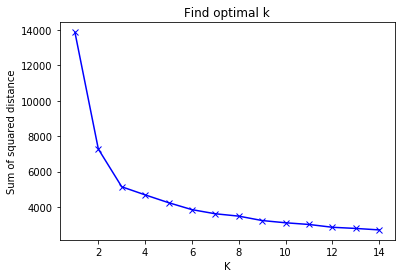

In [148]:
#Check for optimal cluster using elbow method
ssd = []
for k in range(1, 15):
    k_means = KMeans(n_clusters = k)
    model = k_means.fit(BM_grouped_clustering)
    ssd.append(k_means.inertia_)
    
plt.plot(range(1, 15), ssd, 'bx-')
plt.title("Find optimal k")
plt.xlabel("K")
plt.ylabel("Sum of squared distance")
plt.show()

# Thus, optimal value of k is 2

In [149]:
# set number of clusters
kclusters = 2

BM_grouped_clustering = BM_restaurant_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BM_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0])

In [151]:
#Distance from center of both clusters
BM_results = pd.DataFrame(kmeans.cluster_centers_)
BM_results.columns = BM_grouped_clustering.columns
BM_results.index = ['cluster0','cluster1']
BM_results['Total Sum'] = BM_results.sum(axis = 1)
BM_results

,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,...,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Total,Total Sum
cluster0,0.120690,1.931034,0.103448,0.120690,0.672414,1.724138e-01,0.068966,0.017241,1.724138e-02,6.896552e-02,...,0.948276,5.172414e-02,0.258621,6.896552e-02,1.724138e-02,0.810345,3.448276e-02,0.534483,29.137931,58.275862
cluster1,0.019231,1.269231,0.019231,0.019231,0.115385,5.551115e-17,0.057692,0.019231,-1.734723e-18,-6.938894e-18,...,0.346154,-6.938894e-18,0.038462,-6.938894e-18,-1.734723e-18,0.153846,-3.469447e-18,0.153846,13.961538,27.923077


In [154]:
#Group results by Neighborhood, and calculate Total
BM_results_merged = pd.DataFrame(BM_restaurant_grouped['Neighborhood'])

BM_results_merged['Total'] = BM_restaurant_grouped['Total']
BM_results_merged = BM_results_merged.assign(Cluster_Labels = kmeans.labels_)
BM_results_merged

,Neighborhood,Total,Cluster_Labels
0,Bath Beach,33,0
1,Battery Park City,11,1
2,Bay Ridge,32,0
3,Bedford Stuyvesant,21,1
4,Bensonhurst,29,0
...,...,...,...
105,West Village,34,0
106,Williamsburg,25,0
107,Windsor Terrace,20,1
108,Wingate,15,1


In [155]:
#Merge BM_results_merged with BM_Geo
BM_merged = BM_Geo

BM_merged = BM_merged.join(BM_results_merged.set_index('Neighborhood'), on='Neighborhood')

print(BM_merged.shape)
BM_merged.head(10)

(110, 6)


,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,13,1
1,Brooklyn,Bay Ridge,40.625801,-74.030621,32,0
2,Brooklyn,Bensonhurst,40.611009,-73.995180,29,0
3,Brooklyn,Sunset Park,40.645103,-74.010316,39,0
4,Brooklyn,Greenpoint,40.730201,-73.954241,21,1
5,Brooklyn,Gravesend,40.595260,-73.973471,8,1
6,Brooklyn,Brighton Beach,40.576825,-73.965094,20,1
7,Brooklyn,Sheepshead Bay,40.586890,-73.943186,32,0
8,Brooklyn,Manhattan Terrace,40.614433,-73.957438,17,1
9,Brooklyn,Flatbush,40.636326,-73.958401,34,0


In [156]:
# Visualize the clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BM_merged['Latitude'], BM_merged['Longitude'], BM_merged['Neighborhood'], BM_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Cluster 0

In [161]:
BM_merged[BM_merged['Cluster_Labels'] == 0].reset_index(drop=True)


,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,Brooklyn,Bay Ridge,40.625801,-74.030621,32,0
1,Brooklyn,Bensonhurst,40.611009,-73.995180,29,0
2,Brooklyn,Sunset Park,40.645103,-74.010316,39,0
3,Brooklyn,Sheepshead Bay,40.586890,-73.943186,32,0
4,Brooklyn,Flatbush,40.636326,-73.958401,34,0
5,Brooklyn,Crown Heights,40.670829,-73.943291,22,0
6,Brooklyn,Prospect Heights,40.676822,-73.964859,28,0
7,Brooklyn,Williamsburg,40.707144,-73.958115,25,0
8,Brooklyn,Bushwick,40.698116,-73.925258,25,0
9,Brooklyn,Brooklyn Heights,40.695864,-73.993782,23,0


# Cluster 1

In [160]:
BM_merged[BM_merged['Cluster_Labels'] == 1].reset_index(drop=True)

,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,13,1
1,Brooklyn,Greenpoint,40.730201,-73.954241,21,1
2,Brooklyn,Gravesend,40.595260,-73.973471,8,1
3,Brooklyn,Brighton Beach,40.576825,-73.965094,20,1
4,Brooklyn,Manhattan Terrace,40.614433,-73.957438,17,1
5,Brooklyn,East Flatbush,40.641718,-73.936103,5,1
6,Brooklyn,Kensington,40.642382,-73.980421,21,1
7,Brooklyn,Windsor Terrace,40.656946,-73.980073,20,1
8,Brooklyn,Brownsville,40.663950,-73.910235,9,1
9,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,21,1


In [162]:
BM_merged[BM_merged['Total'] == 0].reset_index(drop=True)

,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels


<h6>There are no Untapped Markets for Restaurant business in Brooklyn and Manhattan.

# Segmenting and Clustering Neighborhoods - Bronx, Brooklyn and Queens

In [169]:
BBQ_Geo = nyc_geo.loc[(nyc_geo['Borough'] == 'Bronx')|(nyc_geo['Borough'] == 'Brooklyn')|(nyc_geo['Borough'] == 'Queens')]
BBQ_Geo = BBQ_Geo.reset_index(drop=True)
BBQ_Geo.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [170]:
# Create a map of Bronx, Brooklyn and Queens with neighborhoods superimposed on top.

# create map of Toronto using latitude and longitude values
map_BBQ = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(BBQ_Geo['Latitude'], BBQ_Geo['Longitude'], BBQ_Geo['Borough'], BBQ_Geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_BBQ)  
    
map_BBQ

<h3>Explore the neighborhoods

In [175]:
BBQ_venues = getNearbyVenues(names=BBQ_Geo['Neighborhood'],
                                  latitudes=BBQ_Geo['Latitude'],
                                  longitudes=BBQ_Geo['Longitude'],
                                  LIMIT=200)

print('The "BBQ_venues" dataframe has {} venues and {} unique venue types.'.format(
      len(BBQ_venues['Venue Category']),
      len(BBQ_venues['Venue Category'].unique())))

BBQ_venues.to_csv('BBQ_venues.csv', sep=',', encoding='UTF8')
BBQ_venues.head()


Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Ger

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,Jimbo's,40.891740,-73.858226,Burger Joint


In [176]:
#Get the data
colnames = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
BBQ_venues = pd.read_csv('BBQ_venues.csv', skiprows=1, names=colnames)
BBQ_venues.columns = BBQ_venues.columns.str.replace(' ', '')
BBQ_venues.head()

,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,Jimbo's,40.891740,-73.858226,Burger Joint


In [179]:
# Visualiza the data
bbq_map = venuesMap('New York City, NY', BBQ_venues)

In [181]:
# Get the count of values by category
BBQ_venues.groupby('VenueCategory')['Venue'].count().sort_values(ascending=False)

VenueCategory
Pizza Place           804
Donut Shop            383
Deli / Bodega         374
Coffee Shop           353
Chinese Restaurant    332
                     ... 
Middle School           1
Czech Restaurant        1
Sake Bar                1
Design Studio           1
Kofte Place             1
Name: Venue, Length: 428, dtype: int64

In [182]:
# Group by Neighborhood
BBQ_venues.groupby('Neighborhood').count()

,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Allerton,65,65,65,65,65,65
Arverne,33,33,33,33,33,33
Astoria,100,100,100,100,100,100
Astoria Heights,80,80,80,80,80,80
Auburndale,100,100,100,100,100,100
...,...,...,...,...,...,...
Windsor Terrace,100,100,100,100,100,100
Wingate,73,73,73,73,73,73
Woodhaven,72,72,72,72,72,72


# Analyze the Neighbors

In [183]:
BBQ_onehot = pd.get_dummies(BBQ_venues[['VenueCategory']], prefix="", prefix_sep="")

#column lists before adding neighborhood
column_names = ['Neighborhood'] + list(BBQ_onehot.columns)

# add neighborhood column back to dataframe
BBQ_onehot['Neighborhood'] = BBQ_venues['Neighborhood'] 

# move neighborhood column to the first column
BBQ_onehot = BBQ_onehot[column_names]

BBQ_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
# Get the list of Restaurant
restaurant_List1 = []
search = 'Restaurant'
for i in BBQ_onehot.columns :
    if search in i:
        restaurant_List1.append(i)
restaurant_List1

['Afghan Restaurant',
 'African Restaurant',
 'American Restaurant',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Asian Restaurant',
 'Australian Restaurant',
 'Austrian Restaurant',
 'Brazilian Restaurant',
 'Burmese Restaurant',
 'Cajun / Creole Restaurant',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Caucasian Restaurant',
 'Chinese Restaurant',
 'Colombian Restaurant',
 'Comfort Food Restaurant',
 'Cuban Restaurant',
 'Czech Restaurant',
 'Dim Sum Restaurant',
 'Dumpling Restaurant',
 'Eastern European Restaurant',
 'Egyptian Restaurant',
 'Empanada Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Filipino Restaurant',
 'French Restaurant',
 'German Restaurant',
 'Gluten-free Restaurant',
 'Greek Restaurant',
 'Halal Restaurant',
 'Hawaiian Restaurant',
 'Himalayan Restaurant',
 'Hotpot Restaurant',
 'Indian Restaurant',
 'Indonesian Restaurant',
 'Israeli Restaurant',
 'Italian Restaurant',
 'Japanese Restaurant',
 'Korean Restau

In [189]:
col_name = []
col_name = ['Neighborhood'] + restaurant_List1
BBQ_restaurant = BBQ_onehot[col_name]
BBQ_restaurant = BBQ_restaurant.iloc[:,1::]

In [193]:
# Group by Neighborhood
BBQ_restaurant_grouped = BBQ_restaurant.groupby('Neighborhood').sum().reset_index()

#Calculate total
BBQ_restaurant_grouped['Total'] = BBQ_restaurant_grouped .sum(axis=1)
BBQ_restaurant_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,...,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total
0,Allerton,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
1,Arverne,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
2,Astoria,0,0,1,1,0,0,0,0,1,...,0,0,2,0,0,0,0,1,0,33
3,Astoria Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4,Auburndale,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Windsor Terrace,0,0,3,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,20
199,Wingate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
200,Woodhaven,0,0,2,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,16
201,Woodlawn,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7


# Cluster the neighbors

# We wil use K-means for the clustering

In [194]:
# Determine optimal value of K by silhoutte co-efficient
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
BBQ_grouped_clustering = BBQ_restaurant_grouped.drop('Neighborhood', 1)

for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster).fit(BBQ_grouped_clustering)
    label = kmeans.labels_
    sil_coeff = silhouette_score(BBQ_grouped_clustering, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))


For n_clusters=2, The Silhouette Coefficient is 0.45514732669646235
For n_clusters=3, The Silhouette Coefficient is 0.3317961848888027
For n_clusters=4, The Silhouette Coefficient is 0.30949988991576055
For n_clusters=5, The Silhouette Coefficient is 0.3132536958307755
For n_clusters=6, The Silhouette Coefficient is 0.2493472702118624
For n_clusters=7, The Silhouette Coefficient is 0.20033004782503902
For n_clusters=8, The Silhouette Coefficient is 0.19468679477190787
For n_clusters=9, The Silhouette Coefficient is 0.19696659464700816


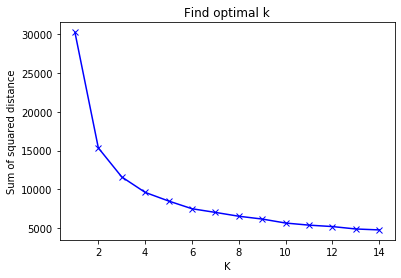

In [195]:

#Check for optimal cluster using elbow method
ssd = []
for k in range(1, 15):
    k_means = KMeans(n_clusters = k)
    model = k_means.fit(BBQ_grouped_clustering)
    ssd.append(k_means.inertia_)
    
plt.plot(range(1, 15), ssd, 'bx-')
plt.title("Find optimal k")
plt.xlabel("K")
plt.ylabel("Sum of squared distance")
plt.show()

<h2> Agian optimal K value is 2

In [196]:
# set number of clusters
kclusters = 2

BBQ_grouped_clustering = BBQ_restaurant_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BBQ_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1])

In [200]:
#Get the distance from centers of both clusters
BBQ_results = pd.DataFrame(kmeans.cluster_centers_)
BBQ_results.columns = BBQ_grouped_clustering.columns
BBQ_results.index = ['cluster0','cluster1']
BBQ_results['Total Sum'] = BBQ_results.sum(axis = 1)
BBQ_results

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Burmese Restaurant,...,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total,Total Sum
cluster0,0.014599,0.029197,0.576642,0.043796,1.526557e-16,0.262774,5.204170e-18,2.081668e-17,0.021898,5.204170e-18,...,7.299270e-03,0.175182,1.459854e-02,-4.857226e-17,0.014599,5.204170e-18,0.072993,0.043796,10.525547,21.051095
cluster1,0.015152,0.045455,1.333333,0.181818,2.121212e-01,0.666667,1.515152e-02,6.060606e-02,0.090909,1.515152e-02,...,4.336809e-18,1.227273,8.673617e-18,1.363636e-01,0.318182,1.515152e-02,0.409091,0.500000,28.469697,56.939394


In [201]:
# Group by Neighborhood and find total
BBQ_results_merged = pd.DataFrame(BBQ_restaurant_grouped['Neighborhood'],)

BBQ_results_merged['Total'] = BBQ_restaurant_grouped['Total']
BBQ_results_merged = BBQ_results_merged.assign(Cluster_Labels = kmeans.labels_)
BBQ_results_merged

,Neighborhood,Total,Cluster_Labels
0,Allerton,12,0
1,Arverne,2,0
2,Astoria,33,1
3,Astoria Heights,9,0
4,Auburndale,34,1
...,...,...,...
198,Windsor Terrace,20,1
199,Wingate,15,0
200,Woodhaven,16,0
201,Woodlawn,7,0


In [202]:
# Merge both data frame
BBQ_merged = BBQ_Geo

BBQ_merged = BBQ_merged.join(BBQ_results_merged.set_index('Neighborhood'), on='Neighborhood')

print(BBQ_merged.shape)
BBQ_merged.head(10)

(203, 6)


,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,Bronx,Wakefield,40.894705,-73.847201,10,0
1,Bronx,Co-op City,40.874294,-73.829939,12,0
2,Bronx,Eastchester,40.887556,-73.827806,13,0
3,Bronx,Fieldston,40.895437,-73.905643,8,0
4,Bronx,Riverdale,40.890834,-73.912585,9,0
5,Bronx,Kingsbridge,40.881687,-73.902818,20,1
6,Bronx,Woodlawn,40.898273,-73.867315,7,0
7,Bronx,Norwood,40.877224,-73.879391,16,0
8,Bronx,Williamsbridge,40.881039,-73.857446,13,0
9,Bronx,Baychester,40.866858,-73.835798,16,0


# Visualize cluster results

In [204]:
# create map
BBQ_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BBQ_merged['Latitude'], BBQ_merged['Longitude'], BBQ_merged['Neighborhood'], BBQ_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(BBQ_clusters)
       
BBQ_clusters

# Cluster 1

In [205]:
BBQ_merged[BBQ_merged['Cluster_Labels'] == 1].reset_index(drop=True)

,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,Bronx,Kingsbridge,40.881687,-73.902818,20,1
1,Bronx,Fordham,40.860997,-73.896427,26,1
2,Bronx,Parkchester,40.837938,-73.856003,27,1
3,Bronx,Belmont,40.857277,-73.888452,25,1
4,Bronx,Unionport,40.829774,-73.850535,20,1
...,...,...,...,...,...,...
61,Queens,Jamaica Hills,40.711460,-73.796465,28,1
62,Queens,Hunters Point,40.743414,-73.953868,30,1
63,Queens,Sunnyside Gardens,40.745652,-73.918193,37,1
64,Brooklyn,Weeksville,40.675040,-73.930531,28,1


# Cluster 0

In [207]:
BBQ_merged[BBQ_merged['Cluster_Labels'] == 0].reset_index(drop=True)

,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,Bronx,Wakefield,40.894705,-73.847201,10,0
1,Bronx,Co-op City,40.874294,-73.829939,12,0
2,Bronx,Eastchester,40.887556,-73.827806,13,0
3,Bronx,Fieldston,40.895437,-73.905643,8,0
4,Bronx,Riverdale,40.890834,-73.912585,9,0
...,...,...,...,...,...,...
132,Bronx,Kingsbridge Heights,40.870392,-73.901523,5,0
133,Brooklyn,Erasmus,40.646926,-73.948177,18,0
134,Queens,Hammels,40.587338,-73.805530,5,0
135,Queens,Bayswater,40.611322,-73.765968,1,0


In [208]:
#Untapped Markets (Total = 0)
BBQ_merged[BBQ_merged['Total'] == 0].reset_index(drop=True)

,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,Bronx,Clason Point,40.806551,-73.854144,0,0
